# Task 3, Training a Variational Auto-Encoder on MNIST

## 1. Initial Setup

For this task we are going to use Tensorflow, Numpy and Matplotlib.

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

## 2. Dataset

The MNIST data can be directly loaded through the Tensorflow Keras API. It is splitted in a training data and a test data, both with their corresponding labels.

In [24]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

For the data preprocessing, we are going to normalize the pixel values between 0 and 1. We also save the shape of a single tensor as it will be relevant for the neural network.

In [25]:
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255
input_shape = x_train[0].shape

## 3. Model
### 3.1 Encoder
The encoder neural network consists mainly in two dense layers of size 256 with ReLU activation functions. The input is flattened through the Flatten layer. The model outputs the mean and the standard deviation of the approximated posterior q(z|x), as well as the sampled z. Both the mean and the standard deviation are obtained through dense layers with as many nodes as latent dimensions, so they can match with the latent variable z. As for z, it is sampled with the reparametrization trick defined in the custom layer Sampling

In [26]:
class Sampling(layers.Layer):
    """Uses (mu, sigma) to sample z"""
    def __init__(self, name):
        super(Sampling, self).__init__()
        self._name = name
        
    def call(self, args):
        mu, sigma = args
        batch = backend.shape(mu)[0]
        dim = backend.shape(mu)[1]
        epsilon = backend.random_normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * sigma) * epsilon

In [27]:
latent_dim = 2

encoder_input = keras.Input(shape=input_shape, name='Input')
x = layers.Flatten(name='Flatten')(encoder_input)
x = layers.Dense(256, activation='relu', name='ReLU1')(x)
x = layers.Dense(256, activation='relu', name='ReLU2')(x)
mu_phi = layers.Dense(latent_dim, name='Mean')(x)
sigma_phi = layers.Dense(latent_dim, activation='sigmoid', name='Variance')(x)                                 
z = Sampling("Z")([mu_phi, sigma_phi])

encoder = keras.models.Model(encoder_input, [mu_phi, sigma_phi, z], name='Encoder')
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 Flatten (Flatten)              (None, 784)          0           ['Input[0][0]']                  
                                                                                                  
 ReLU1 (Dense)                  (None, 256)          200960      ['Flatten[0][0]']                
                                                                                                  
 ReLU2 (Dense)                  (None, 256)          65792       ['ReLU1[0][0]']                  
                                                                                            

### 3.2 Decoder

The decoder also consists mainly in two dense layers of size 256 with ReLU activation functions. The input comes from the encoder output, therefore it has the shape of the latent dimension. At the end of the decoder, the output is reconstructed by reshaping it to the corresponding dimensions.

In [28]:
decoder_input = keras.Input(shape=(latent_dim, ), name='Input')
x = layers.Dense(256, activation='relu', name='ReLU1')(decoder_input)
x = layers.Dense(256, activation='relu', name='ReLU2')(x)
y = layers.Dense(784, name="Output")(x)
y = layers.Reshape(input_shape, name="Reshape")(y)
decoder = keras.Model(decoder_input, y, name='Decoder')
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 ReLU1 (Dense)               (None, 256)               768       
                                                                 
 ReLU2 (Dense)               (None, 256)               65792     
                                                                 
 Output (Dense)              (None, 784)               201488    
                                                                 
 Reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 268,048
Trainable params: 268,048
Non-trainable params: 0
_________________________________________________________________


## 4. ELBO Loss and VAE Model

In [29]:
class ELBOLoss(layers.Layer):
    
    def elbo_loss(self, x, z_decoded):
        x = tf.keras.backend.flatten(x)
        z_decoded = tf.keras.backend.flatten(z_decoded)
        
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        kl_loss = -5e-4 * tf.keras.backend.mean(1 + sigma_phi - tf.keras.backend.square(mu_phi) - tf.keras.backend.exp(sigma_phi), axis=-1)
        return tf.keras.backend.mean(recon_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.elbo_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

In [30]:
z_decoded = decoder(z)
y = ELBOLoss()([encoder_input, z_decoded])

In [31]:
vae = keras.Model(encoder_input, y, name='VAE')
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001)) 
vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 Flatten (Flatten)              (None, 784)          0           ['Input[0][0]']                  
                                                                                                  
 ReLU1 (Dense)                  (None, 256)          200960      ['Flatten[0][0]']                
                                                                                                  
 ReLU2 (Dense)                  (None, 256)          65792       ['ReLU1[0][0]']                  
                                                                                                

## 5. Training and Visualization

### 5.1 Latent Space Visualization

In [143]:
def plot_latent_space(encoder, data, labels):
    mu, _, _ = encoder.predict(data)
    #Plot dim1 and dim2 for mu
    plt.figure(figsize=(10, 10))
    cmap = plt.get_cmap('RdBu', np.max(labels) - np.min(labels) + 1)
    plt.scatter(mu[:, 0], mu[:, 1], c=labels, cmap=cmap, vmin=np.min(labels) - 0.5, vmax=np.max(labels) + 0.5)
    plt.xlabel('dim 1')
    plt.ylabel('dim 2')
    plt.colorbar(ticks=np.arange(np.min(y_test), np.max(y_test) + 1))
    plt.show()
    
def plot_reconstructed(encoder, decoder, data):
    _, _, z = encoder.predict(prueba)
    reconstructed = decoder.predict(z)
    rows = 6
    cols = 5
    fig, ax = plt.subplots(rows, cols, figsize=(10,10))
    index1 = 0
    index2 = 0
    for i in range(rows):
        for j in range(cols):
            ax[i,j].axis('off')
            if (i % 2 == 0):
                ax[i,j].imshow(data[index1])
                index1 += 1
            else:
                ax[i,j].imshow(reconstructed[index2])
                index2 += 1
    
def plot_generated(decoder, sample):
    rows = 3
    cols = 5
    decoded = decoder.predict(sample)
    fig, ax = plt.subplots(rows, cols, figsize=(8, 8))

    for i in range(rows):
        for j in range(cols):
            ax[i,j].axis('off')
            ax[i,j].imshow(decoded[i * cols + j])


### 5.2 Training

Train on 48000 samples, validate on 12000 samples
48000/48000 [==============================] - 4s 81us/sample - loss: 0.2530 - val_loss: 0.2499


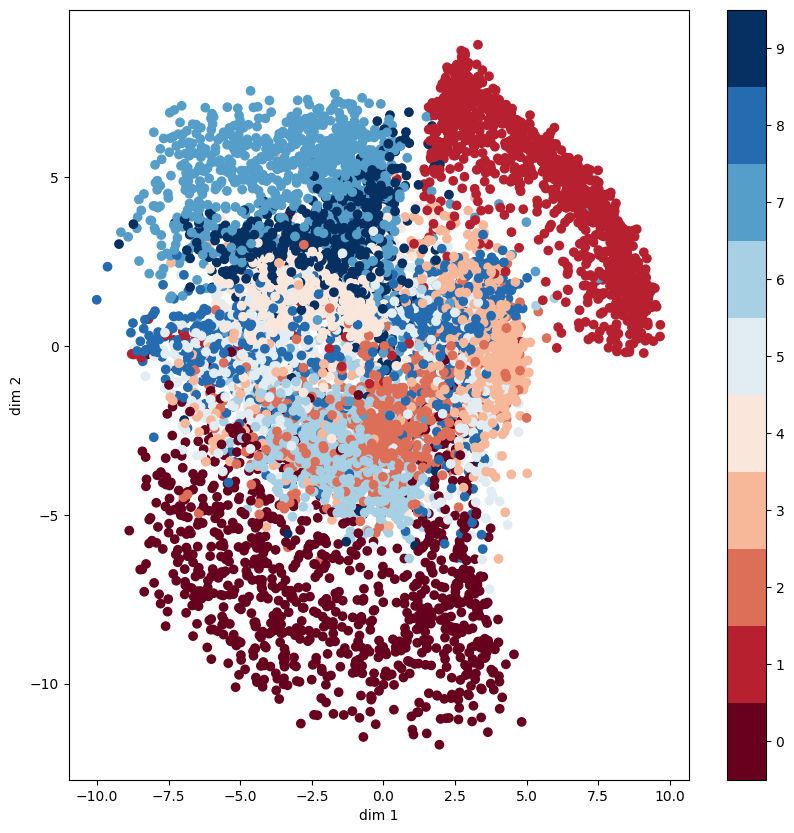

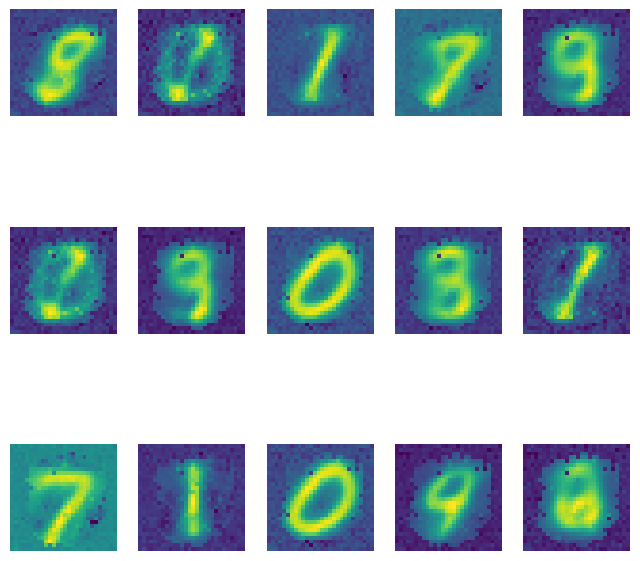

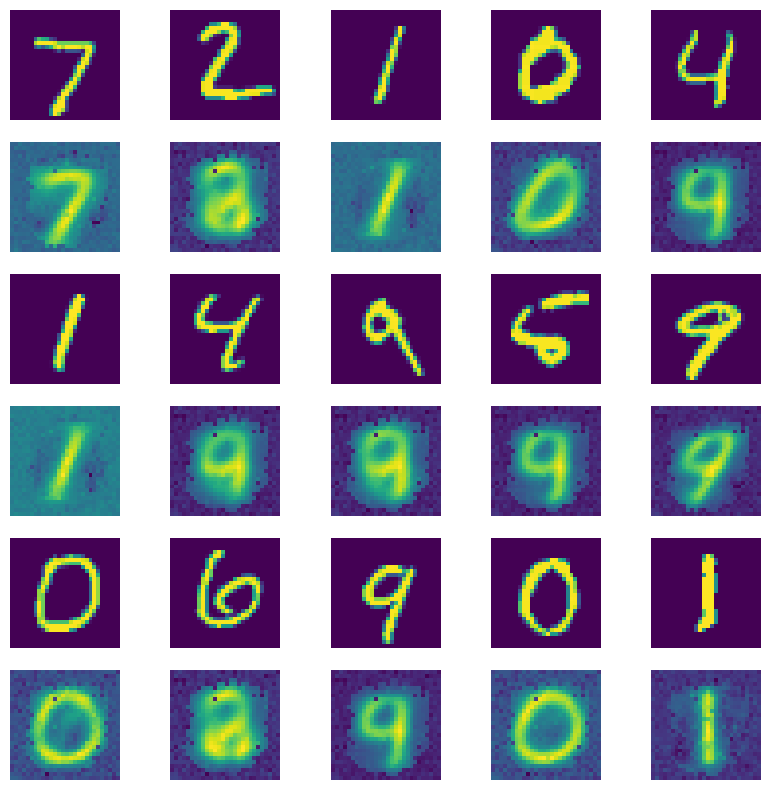

In [153]:
vae.fit(x_train, None, epochs = 1, batch_size = 128, validation_split = 0.2)
plot_latent_space(encoder, x_test, y_test)
sample = np.random.uniform(low=-10.0, high=10.0, size=(15,2))
plot_generated(decoder, sample)
plot_reconstructed(encoder, decoder, x_test[0:15])

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 4s 80us/sample - loss: 0.2516 - val_loss: 0.2529
Epoch 2/5
48000/48000 [==============================] - 4s 80us/sample - loss: 0.2495 - val_loss: 0.2491
Epoch 3/5
48000/48000 [==============================] - 4s 80us/sample - loss: 0.2551 - val_loss: 0.2529
Epoch 4/5
48000/48000 [==============================] - 4s 80us/sample - loss: 0.2559 - val_loss: 0.2569
Epoch 5/5
48000/48000 [==============================] - 4s 80us/sample - loss: 0.2534 - val_loss: 0.2511


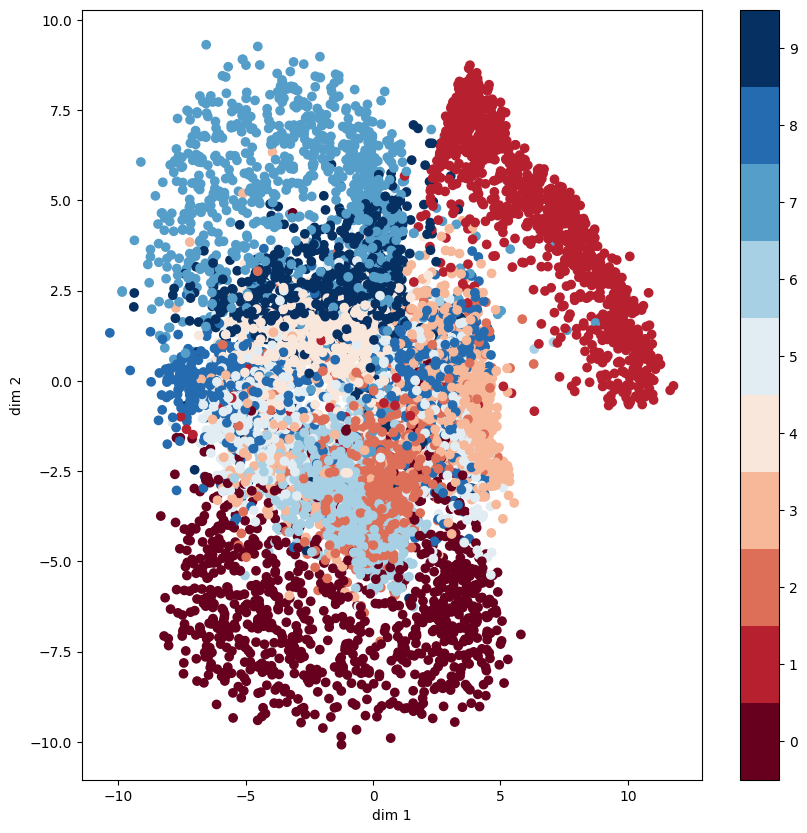

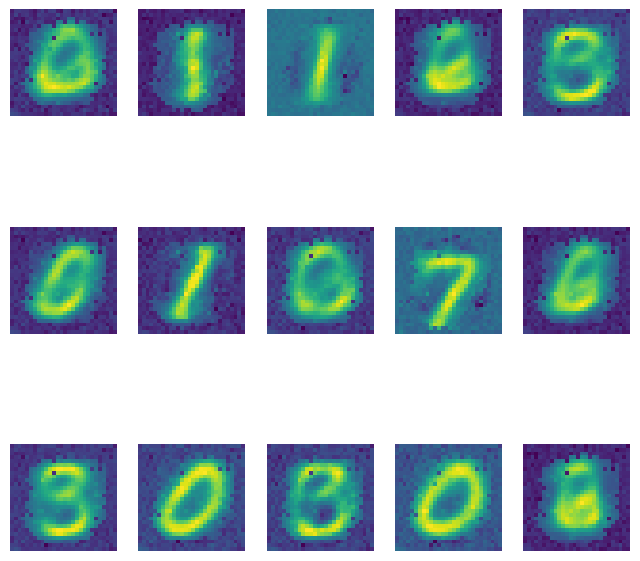

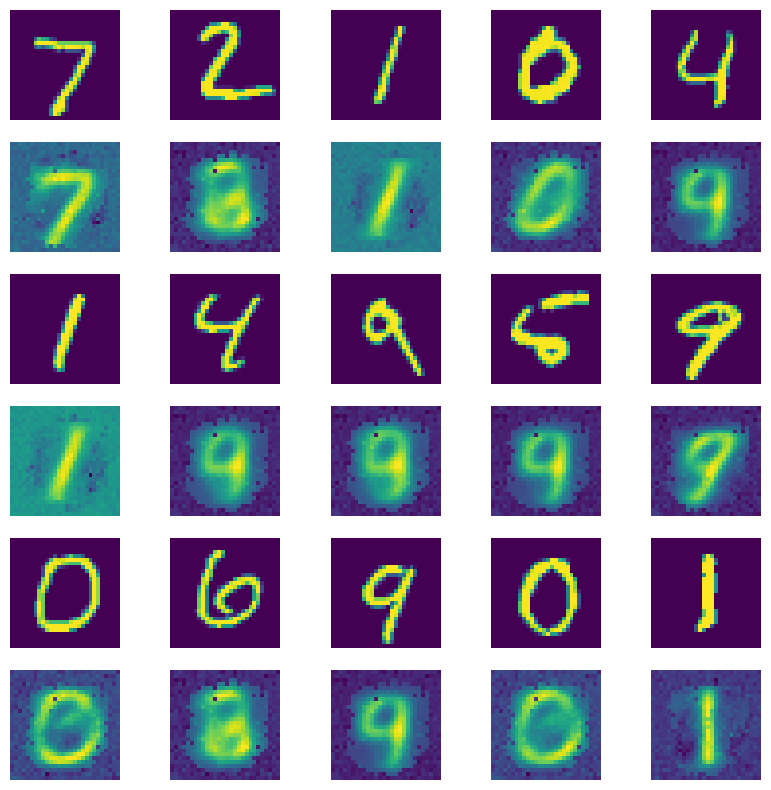

In [154]:
vae.fit(x_train, None, epochs = 5, batch_size = 128, validation_split = 0.2)
plot_latent_space(encoder, x_test, y_test)
sample = np.random.uniform(low=-10.0, high=10.0, size=(15,2))
plot_generated(decoder, sample)
plot_reconstructed(encoder, decoder, x_test[0:15])

Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 4s 82us/sample - loss: 0.2509 - val_loss: 0.2499
Epoch 2/25
48000/48000 [==============================] - 4s 81us/sample - loss: 0.2541 - val_loss: 0.2535
Epoch 3/25
48000/48000 [==============================] - 4s 80us/sample - loss: 0.2537 - val_loss: 0.2513
Epoch 4/25
48000/48000 [==============================] - 4s 81us/sample - loss: 0.2530 - val_loss: 0.2504
Epoch 5/25
48000/48000 [==============================] - 4s 79us/sample - loss: 0.2548 - val_loss: 0.2545
Epoch 6/25
48000/48000 [==============================] - 4s 80us/sample - loss: 0.2524 - val_loss: 0.2494
Epoch 7/25
48000/48000 [==============================] - 4s 80us/sample - loss: 0.2495 - val_loss: 0.2482
Epoch 8/25
48000/48000 [==============================] - 4s 80us/sample - loss: 0.2488 - val_loss: 0.2483
Epoch 9/25
48000/48000 [==============================] - 4s 79us/sample - loss: 0.2522 - val_

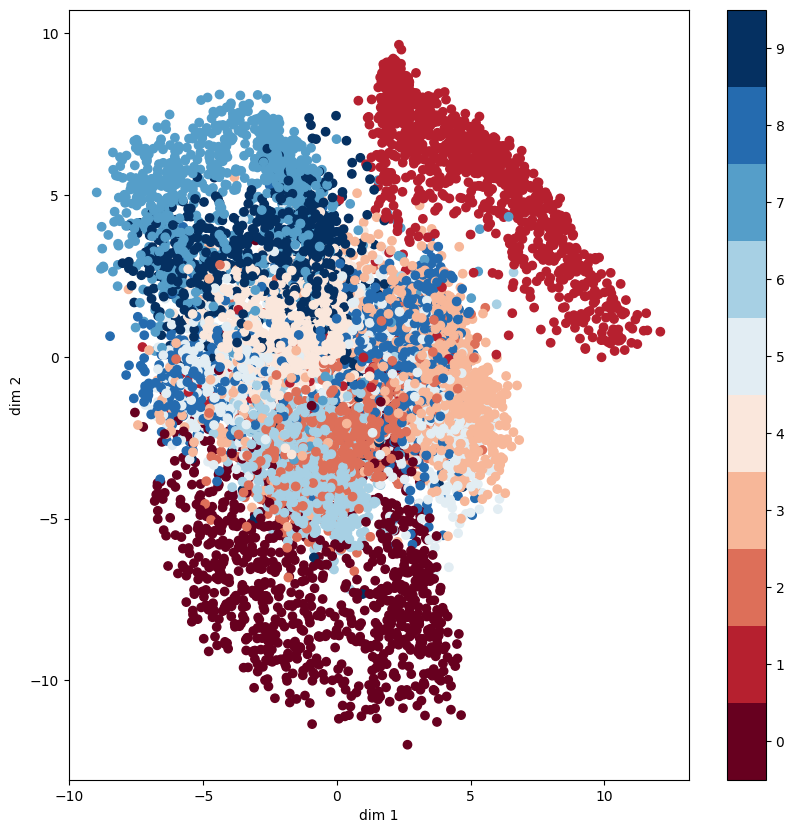

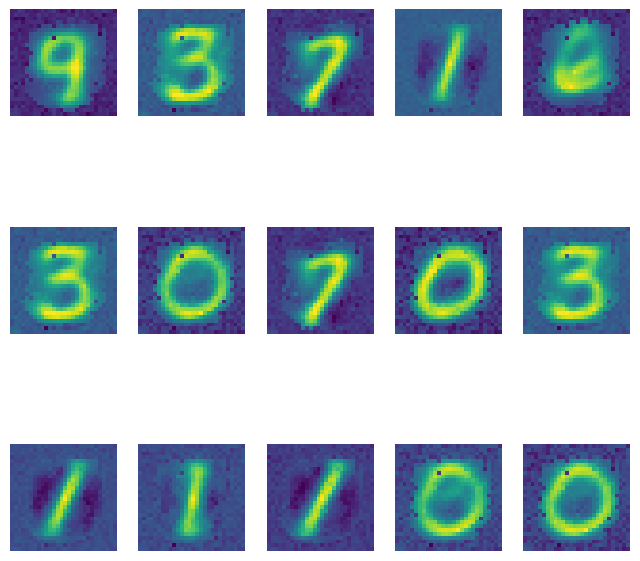

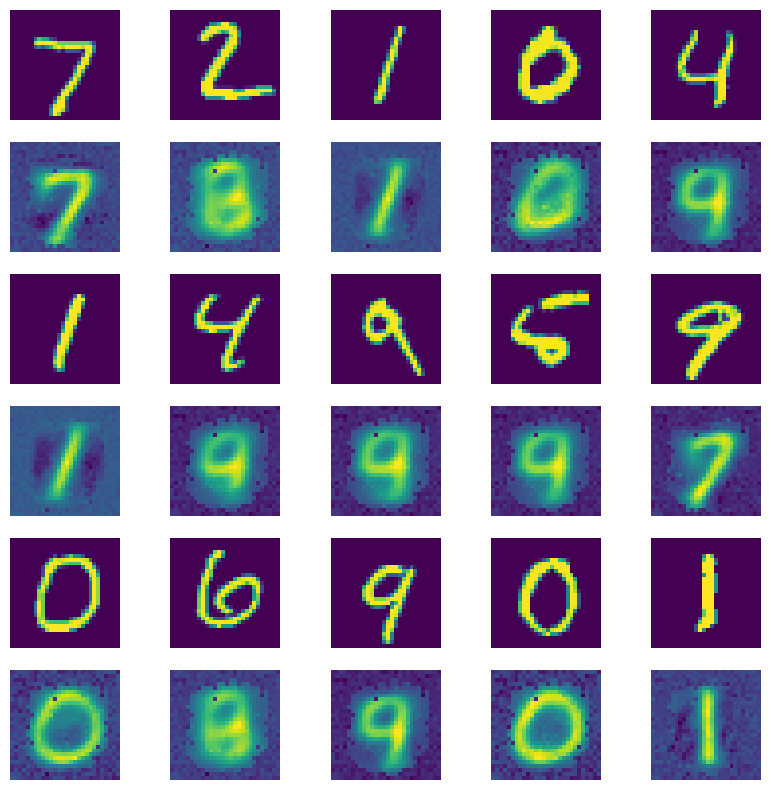

In [155]:
vae.fit(x_train, None, epochs = 25, batch_size = 128, validation_split = 0.2)
plot_latent_space(encoder, x_test, y_test)
sample = np.random.uniform(low=-10.0, high=10.0, size=(15,2))
plot_generated(decoder, sample)
plot_reconstructed(encoder, decoder, x_test[0:15])

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 4s 81us/sample - loss: 0.2491 - val_loss: 0.2471
Epoch 2/50
48000/48000 [==============================] - 4s 80us/sample - loss: 0.2497 - val_loss: 0.2493
Epoch 3/50
48000/48000 [==============================] - 4s 80us/sample - loss: 0.2495 - val_loss: 0.2478
Epoch 4/50
48000/48000 [==============================] - 4s 82us/sample - loss: 0.2490 - val_loss: 0.2480
Epoch 5/50
48000/48000 [==============================] - 4s 82us/sample - loss: 0.2495 - val_loss: 0.2480
Epoch 6/50
48000/48000 [==============================] - 4s 81us/sample - loss: 0.2501 - val_loss: 0.2477
Epoch 7/50
48000/48000 [==============================] - 4s 83us/sample - loss: 0.2515 - val_loss: 0.2480
Epoch 8/50
48000/48000 [==============================] - 4s 81us/sample - loss: 0.2506 - val_loss: 0.2501
Epoch 9/50
48000/48000 [==============================] - 4s 80us/sample - loss: 0.2520 - val_

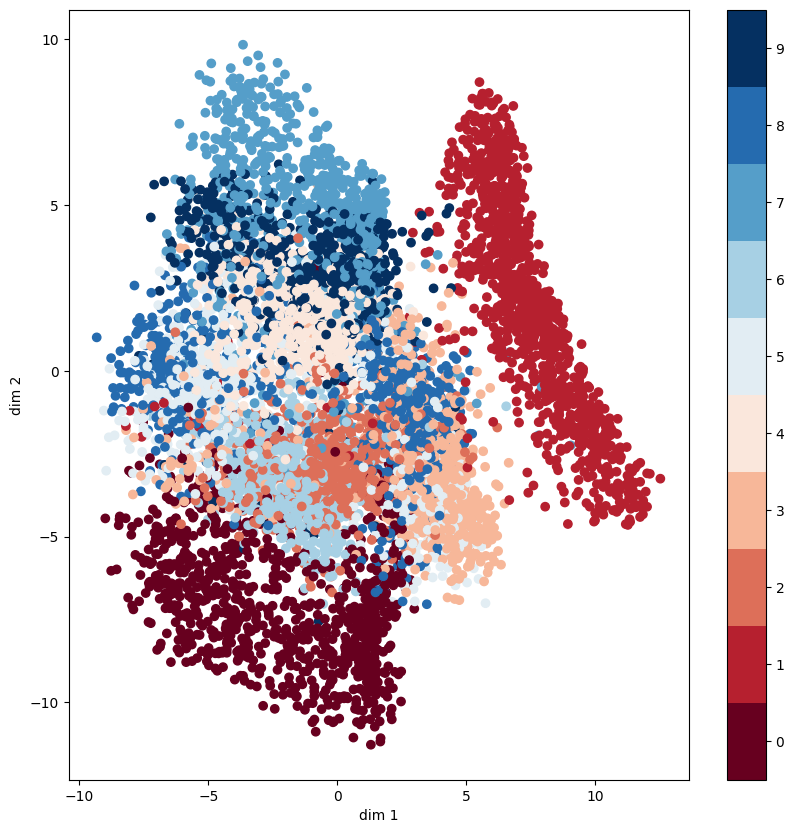

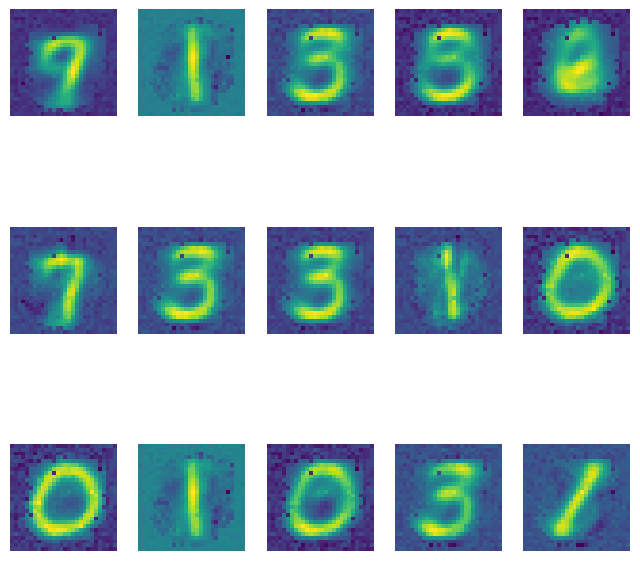

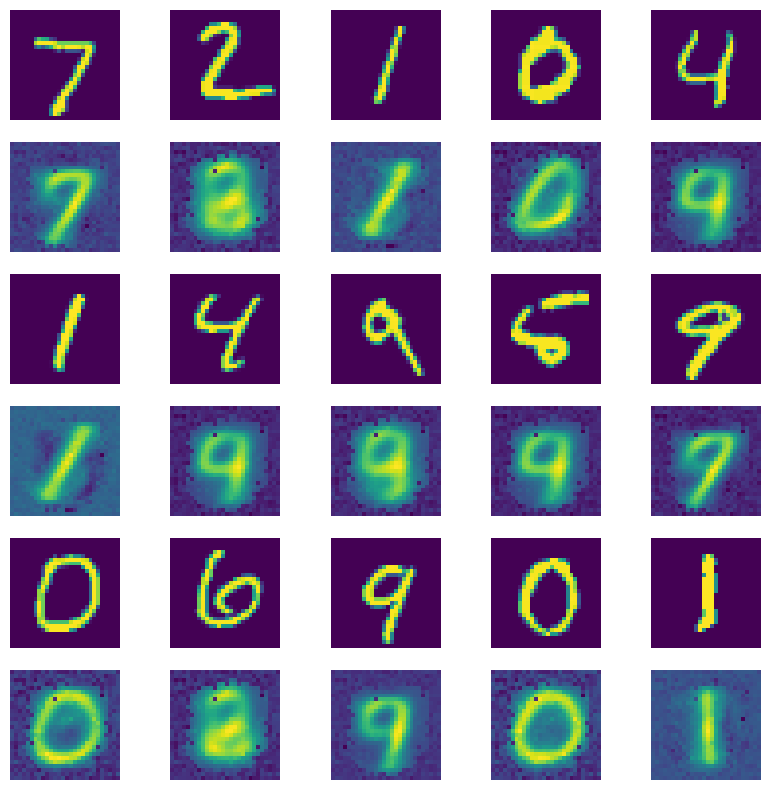

In [156]:
vae.fit(x_train, None, epochs = 50, batch_size = 128, validation_split = 0.2)
plot_latent_space(encoder, x_test, y_test)
sample = np.random.uniform(low=-10.0, high=10.0, size=(15,2))
plot_generated(decoder, sample)
plot_reconstructed(encoder, decoder, x_test[0:15])
